# Assignment - 7- A
## Neural Style Transfer

## Introduction

Style transfer consists in generating an image
with the same "content" as a base image, but with the
"style" of a different picture (typically artistic).
This is achieved through the optimization of a loss function
that has 3 components: "style loss", "content loss",
and "total variation loss":

- The total variation loss imposes local spatial continuity between
the pixels of the combination image, giving it visual coherence.
- The style loss is where the deep learning keeps in --that one is defined
using a deep convolutional neural network. Precisely, it consists in a sum of
L2 distances between the Gram matrices of the representations of
the base image and the style reference image, extracted from
different layers of a convnet (trained on ImageNet). The general idea
is to capture color/texture information at different spatial
scales (fairly large scales --defined by the depth of the layer considered).
- The content loss is a L2 distance between the features of the base
image (extracted from a deep layer) and the features of the combination image,
keeping the generated image close enough to the original one.

## Tasks

1. Import the content image and style image using below given code.
2. Perform standard preprocessing ( Convrting dtype of image, resize and adding batch dimension)
3. Write functions to calculate Style loss, content loss and total variation loss and gram matrix.
4. Import pretrained VGG/Resnet Model. We will be using this to extract embedding for content and style images. Set trainable to False.
5. Select layers for extracting content and style information. For VGG19, a typical combination is provided below. Feel free to experiment with different layers.
6. Perform model training with number of epochs set to higher number(Ex- 5000's). Use early stopping call back to monitor loss and stop if there is no improvement in performance. (Ex- When decrement is loss is less than 50 , then stop)
7. Print the final transformed image along side content and style image.
8. Now consider any other example set ( Your own set of content and style images ). Pass it through the network without training and print the resultant image.

Ref- https://arxiv.org/abs/1508.06576

## Note -

Change the runtime type to T4 GPU on your colab. Without GPU , the model takes much longer.

### Task 1

In [1]:
nightcanvas_image="https://cdn.britannica.com/78/43678-050-F4DC8D93/Starry-Night-canvas-Vincent-van-Gogh-New-1889.jpg"
dog_image= "https://kb.rspca.org.au/wp-content/uploads/2018/11/golder-retriever-puppy.jpeg"

In [2]:
from google.colab import files as FILE
import requests

img_data = requests.get(nightcanvas_image).content
with open('nightcanvas_image.jpg', 'wb') as handler:
    handler.write(img_data)

img_data = requests.get(dog_image).content
with open('dog.jpeg', 'wb') as handler:
    handler.write(img_data)

In [3]:
content_image_path = 'dog.jpeg'
style_image_path = 'nightcanvas_image.jpg'

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

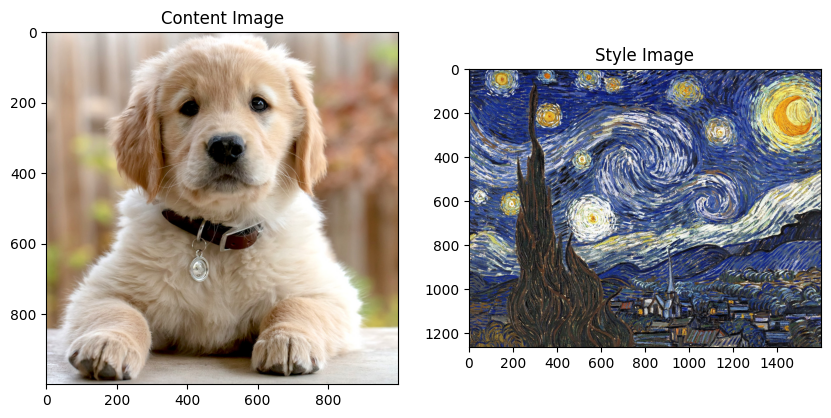

In [5]:
# Load the content and style images
content = plt.imread(content_image_path)
style = plt.imread(style_image_path)

# Display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 12))

# Content and style images side-by-side
ax1.imshow(content)
ax1.set_title('Content Image')
ax2.imshow(style)
ax2.set_title('Style Image')
plt.show()


In [6]:
## Content and Style layers when you are trying Resnet
# Content layer
content_layers = ['conv1_conv']

# Style layer
style_layers = ['conv2_block1_2_bn',
                'conv3_block1_1_bn',
                'conv3_block2_1_bn',
                'conv4_block1_2_bn',
                'conv5_block1_2_bn']

## Content and Style layers when you are trying VGG19

style_layer = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
content_layer = "block5_conv2"

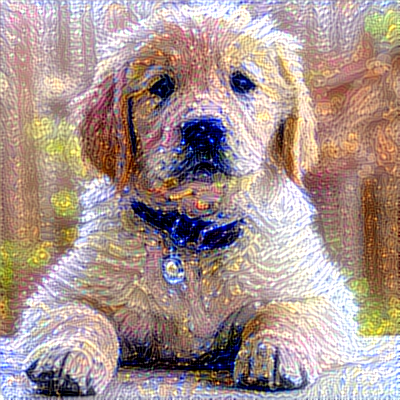

### Task 2

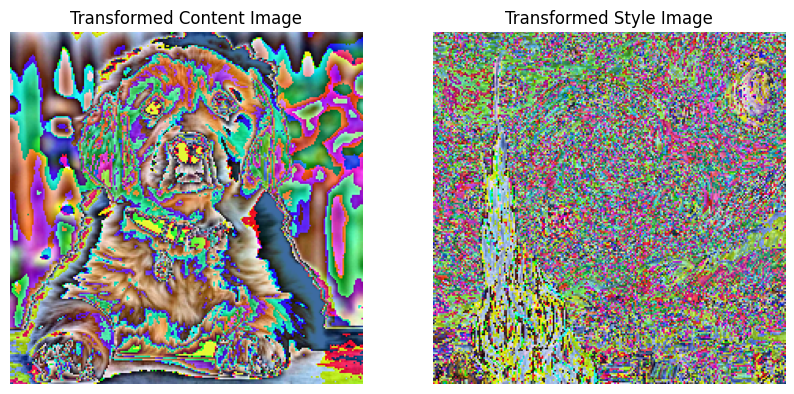

In [7]:
import torch
import torchvision.transforms as transforms

# Set up the transformations
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),  # Resize the image to 224x224 for VGG19 or ResNet
    transforms.ToTensor(),  # Convert the PIL image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize with ImageNet's mean and std
    transforms.Lambda(lambda x: x.unsqueeze(0)),  # Add a batch dimension
])

# Apply the transformations to the content and style images
content_image_transformed = preprocess(content)
style_image_transformed = preprocess(style)

# If you need to visualize the transformed images
def imshow(tensor, ax=None, title=None):
    unloader = transforms.ToPILImage()  # Convert back to PIL image
    image = tensor.cpu().clone()  # Clone the tensor to not do changes on it
    image = image.squeeze(0)  # Remove the batch dimension
    image = unloader(image)
    if ax is None:
        fig, ax = plt.subplots()
    ax.imshow(image)
    if title is not None:
        ax.set_title(title)
    ax.axis('off')

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
imshow(content_image_transformed, ax=ax1, title='Transformed Content Image')
imshow(style_image_transformed, ax=ax2, title='Transformed Style Image')
plt.show()


### Task 3

In [8]:
import torch

# Gram Matrix
def gram_matrix(input):
    batch_size, feature_maps, h, w = input.size()
    features = input.view(batch_size * feature_maps, h * w)
    G = torch.mm(features, features.t())
    return G.div(batch_size * feature_maps * h * w)

# Content Loss
def content_loss(content_weight, content_current, content_target):
    return content_weight * torch.nn.functional.mse_loss(content_current, content_target)

# Style Loss
def style_loss(style_weight, style_current, style_target):
    G_current = gram_matrix(style_current)
    G_target = gram_matrix(style_target)
    return style_weight * torch.nn.functional.mse_loss(G_current, G_target)

# Total Variation Loss
def total_variation_loss(img, tv_weight):
    # Total variation loss encourages spatial smoothness in the generated image
    batch_size, channels, h, w = img.size()
    tv_loss = torch.sum(torch.abs(img[:, :, :, :-1] - img[:, :, :, 1:])) + \
              torch.sum(torch.abs(img[:, :, :-1, :] - img[:, :, 1:, :]))
    return tv_weight * (tv_loss / (batch_size * channels * h * w))



In [9]:
content_feature_map_size = [1, 512, 64, 64]
style_feature_map_size = [1, 512, 64, 64]  # [batch_size, channels, height, width]

# Create random tensors to simulate feature maps from the content and style images
content_feature = torch.rand(content_feature_map_size)
style_feature = torch.rand(style_feature_map_size)

# Create a random tensor to simulate the current image's feature map
current_feature = torch.rand(content_feature_map_size, requires_grad=True)

content_weight = 1
style_weight = 1e6
tv_weight = 1e-3

# Test the content loss function
content_loss_val = content_loss(content_weight, current_feature, content_feature)
print('Content Loss:', content_loss_val.item())

# Test the style loss function
style_loss_val = style_loss(style_weight, current_feature, style_feature)
print('Style Loss:', style_loss_val.item())

# Test the total variation loss function
current_image = torch.rand([1, 3, 256, 256], requires_grad=True)
tv_loss_val = total_variation_loss(current_image, tv_weight)
print('Total Variation Loss:', tv_loss_val.item())

Content Loss: 0.1666368693113327
Style Loss: 9.558033343637362e-05
Total Variation Loss: 0.0006655061151832342


### Task 4

For VGG19

In [10]:
import torchvision.models as models

# Load the VGG19 model pretrained on ImageNet data
vgg19 = models.vgg19(pretrained=True).features

# Freeze all the parameters in the model
for param in vgg19.parameters():
    param.requires_grad = False

# Transfer the model to GPU
if torch.cuda.is_available():
    vgg19 = vgg19.cuda()


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


For ResNet

In [11]:
# Load the ResNet model pretrained on ImageNet data
resnet = models.resnet50(pretrained=True)

resnet = torch.nn.Sequential(*(list(resnet.children())[:-2]))

# Freeze all the parameters in the model
for param in resnet.parameters():
    param.requires_grad = False

# Transfer the model to GPU
if torch.cuda.is_available():
    resnet = resnet.cuda()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Task 5

In [12]:
# Define a function to get the selected layers
def get_style_content_layers(model):
    content_layers = ['block5_conv2']
    style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

    content_features = []
    style_features = []
    model_children = list(model.children())

    # Initialize a counter to keep track of the convolutional layers
    conv_counter = 0
    block_counter = 1

    for layer in model_children:
        if isinstance(layer, torch.nn.Conv2d):
            conv_counter += 1
            name = f'block{block_counter}_conv{conv_counter}'
            if name in content_layers:
                content_features.append(layer)
            if name in style_layers:
                style_features.append(layer)

        # Reset conv_counter after each MaxPool2d
        if isinstance(layer, torch.nn.MaxPool2d):
            block_counter += 1
            conv_counter = 0  # Reset the counter at the end of each block

    return content_features, style_features

In [13]:
# Load the pre-trained VGG19 model
vgg19 = models.vgg19(pretrained=True).features

# Test the function
content_layers, style_layers = get_style_content_layers(vgg19)


print("Content layers:")
for layer in content_layers:
    print(layer)

print("Style layers:")
for layer in style_layers:
    print(layer)

assert isinstance(content_layers[0], torch.nn.modules.conv.Conv2d), "The content layer should be of type Conv2d"
assert all(isinstance(layer, torch.nn.modules.conv.Conv2d) for layer in style_layers), "All style layers should be of type Conv2d"

print("Test passed: Correct layers have been extracted.")


Content layers:
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Style layers:
Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Test passed: Correct layers have been extracted.


### Task 6

In [57]:
import tensorflow as tf
import numpy as np
import requests
from PIL import Image
from io import BytesIO
import tensorflow.keras.applications.vgg19 as vgg19
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array

# Function to preprocess the image and make it VGG19 ready
def preprocess_image(image_url, target_size=(400, 400)):
    response = requests.get(image_url)
    img = Image.open(BytesIO(response.content))
    img = img.resize(target_size)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

# Function to deprocess the image and make it human viewable
def deprocess_image(x):
    x = x.reshape((x.shape[1], x.shape[2], 3))
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

# EarlyStopping class
class EarlyStopping:
    def __init__(self, patience=20, min_delta=50):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = np.inf
        self.early_stop = False

    def step(self, loss):
        if loss < self.best_loss - self.min_delta:
            self.best_loss = loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [76]:
def gram_matrix(x):
    if tf.rank(x) == 3:
        x = tf.expand_dims(x, axis=0)
    x = tf.transpose(x, (0, 3, 1, 2))
    features = tf.reshape(x, (tf.shape(x)[0], -1, tf.shape(x)[2] * tf.shape(x)[3]))
    gram = tf.matmul(features, features, transpose_b=True)
    return gram

def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels**2) * (size**2))

def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))

def total_variation_loss(x):
    a = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :]
    )
    b = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))



In [69]:
# List of layers to use for the style loss.
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
# The layer to use for the content loss.
content_layer_name = "block5_conv2"


def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)

    # Initialize the loss
    loss = tf.zeros(shape=())

    # Add content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    # Add style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl

    # Add total variation loss
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss


In [70]:
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

In [77]:
# Load VGG19 model pre-trained on ImageNet data
model = vgg19.VGG19(weights='imagenet', include_top=False)
model.trainable = False

# Define content and style layers
content_layers = ['block5_conv2']
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']



# Load content and style images
content_image_url = "https://kb.rspca.org.au/wp-content/uploads/2018/11/golder-retriever-puppy.jpeg"
style_image_url = "https://cdn.britannica.com/78/43678-050-F4DC8D93/Starry-Night-canvas-Vincent-van-Gogh-New-1889.jpg"
content_image = preprocess_image(content_image_url)
style_image = preprocess_image(style_image_url)


# Assuming both images are of the same size
img_nrows, img_ncols, _ = content_image.shape[1:4]

# Define optimizer
optimizer = tf.optimizers.Adam(learning_rate=0.02)

# Define the weights for each type of loss
content_weight = 1
style_weight = 1e6
tv_weight = 1e-3

In [78]:
def load_image(url, max_size=400, shape=None):
    response = requests.get(url)
    image = Image.open(BytesIO(response.content)).convert('RGB')

    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    if shape is not None:
        size = shape

    in_transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

    # Avoid alpha channel issues by adding [:3]
    image = in_transform(image)[:3, :, :].unsqueeze(0)

    return image

In [79]:
def train(content_image, style_image, model, optimizer, content_weight, style_weight, tv_weight, iterations, early_stopping):
    # Create a TensorFlow variable for the target image
    combination_image = tf.Variable(content_image, dtype=tf.float32)

    # Get the content and style features
    content_features = get_features(content_image, model, content_layers)
    style_features = get_features(style_image, model, style_layers)

    # Optimization loop
    for i in range(iterations):
        with tf.GradientTape() as tape:
            # Get the features of the combination image
            combination_features = get_features(combination_image, model, content_layers + style_layers)

            # Compute the content loss
            content_loss_val = content_loss(combination_features[content_layers[0]], content_features[content_layers[0]]) * content_weight

            # Compute the style loss
            style_loss_val = tf.add_n([style_loss(combination_features[layer], style_features[layer]) for layer in style_layers]) * (style_weight / len(style_layers))

            # Compute the total variation loss
            tv_loss_val = total_variation_loss(combination_image) * tv_weight

            # Total loss
            total_loss = content_loss_val + style_loss_val + tv_loss_val

        # Compute gradients and apply them
        grads = tape.gradient(total_loss, combination_image)
        optimizer.apply_gradients([(grads, combination_image)])

        # Early stopping check
        if early_stopping.step(total_loss.numpy()):
            print(f"Early stopping at iteration {i}, loss: {total_loss.numpy()}")
            break

        if i % 100 == 0:
            print(f"Iteration {i}, Total loss: {total_loss.numpy()}")

    # Ensure the image values are in the valid range [0, 255]
    final_img = combination_image.numpy()
    final_img = np.clip(final_img, 0, 255).astype('uint8')
    return final_img

# Function to extract features from an image using the specified layers
def get_features(image, model, layers):
    outputs = [model.get_layer(name).output for name in layers]
    feature_model = Model(inputs=model.input, outputs=outputs)
    features = feature_model(image)
    return {layer_name: feature for layer_name, feature in zip(layers, features)}


In [80]:
# Instantiate the EarlyStopping class
early_stopping = EarlyStopping(patience=20, min_delta=50)

# Run the training loop
final_img = train(
    content_image, style_image, model, optimizer,
    content_weight, style_weight, tv_weight,
    iterations=5000, early_stopping=early_stopping
)


Iteration 0, Total loss: 8.881008820617216e+16
Iteration 100, Total loss: 7.471230473365094e+16
Iteration 200, Total loss: 6.021467269077402e+16
Iteration 300, Total loss: 4.816862945529037e+16
Iteration 400, Total loss: 3.862651349866906e+16
Iteration 500, Total loss: 3.1320808487911424e+16
Iteration 600, Total loss: 2.582809507214131e+16
Iteration 700, Total loss: 2.170848055341875e+16
Iteration 800, Total loss: 1.855132955102413e+16
Iteration 900, Total loss: 1.6075865020432384e+16
Iteration 1000, Total loss: 1.4099128871026688e+16
Iteration 1100, Total loss: 1.2484791324639232e+16
Iteration 1200, Total loss: 1.114242291859456e+16
Iteration 1300, Total loss: 1.0010202967375872e+16
Iteration 1400, Total loss: 9046219032625152.0
Iteration 1500, Total loss: 8222826020470784.0
Iteration 1600, Total loss: 7513098244063232.0
Iteration 1700, Total loss: 6896918613458944.0
Iteration 1800, Total loss: 6356504353439744.0
Iteration 1900, Total loss: 5879125717811200.0
Iteration 2000, Total los

### Task 7

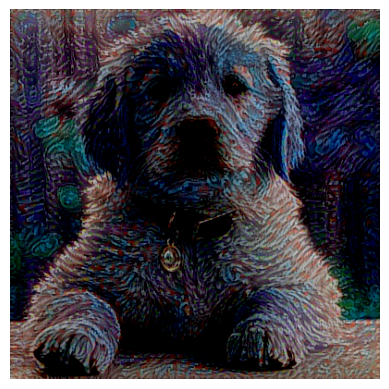

In [83]:
final_img_displayable = np.squeeze(np.clip(final_img, 0, 255).astype('uint8'))


plt.imshow(final_img_displayable)
plt.axis('off')
plt.show()

### Task 8

In [92]:
new_content_image_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg"
new_style_image_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg"

In [110]:
model = vgg19.VGG19(weights='imagenet', include_top=False)
model.trainable = False
outputs = [model.get_layer(name).output for name in style_layers + content_layers]
feature_extractor = Model(inputs=model.input, outputs=outputs)

# Define the weights for each type of loss
content_weight = 1.0
style_weight = 1e6
total_variation_weight = 1e-3

def compute_loss(combination_image, base_image, style_reference_image, feature_extractor, content_weight, style_weight, total_variation_weight):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    feature_outputs = feature_extractor(input_tensor)

    # Initialize the loss
    loss = tf.zeros(shape=())

    # Compute the content loss
    # Get the index of 'block5_conv2' from content_layers, which should be 0 as it's the only content layer
    content_layer_features = feature_outputs[content_layers.index('block5_conv2')]
    base_image_features = content_layer_features[0, :, :, :]
    combination_features = content_layer_features[2, :, :, :]
    loss += content_weight * content_loss(base_image_features, combination_features)

    # Compute the style loss
    # Now loop through each style layer and get their corresponding features from feature_outputs
    for layer_name in style_layer_names:
        layer_features = feature_outputs[style_layers.index(layer_name)]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl

    # Add the total variation loss
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss


@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(
            combination_image,
            base_image,
            style_reference_image,
            feature_extractor,  # Captured from the outer scope
            content_weight,     # Captured from the outer scope
            style_weight,       # Captured from the outer scope
            total_variation_weight  # Captured from the outer scope
        )
    grads = tape.gradient(loss, combination_image)
    return loss, grads

In [111]:
# Now we can proceed with the new images
new_content_image = preprocess_image(new_content_image_url, target_size=(img_nrows, img_ncols))
new_style_image = preprocess_image(new_style_image_url, target_size=(img_nrows, img_ncols))

# Create a combination image initialized with the content image
combination_image = tf.Variable(new_content_image, dtype=tf.float32)

# Compute the loss and gradients for the combination image
loss, grads = compute_loss_and_grads(
    combination_image,
    new_content_image,
    new_style_image
)

# Apply one update step using the gradients
optimizer.apply_gradients([(grads, combination_image)])

# Deprocess the combination image to convert it to a viewable format
final_img = deprocess_image(combination_image.numpy())

# Display the image
plt.imshow(final_img)
plt.axis('off')  # Hide the axis
plt.show()

ValueError: ignored

In [112]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [113]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [114]:
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

195196/195196 [==============================] - 0s 1us/step


In [115]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [116]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

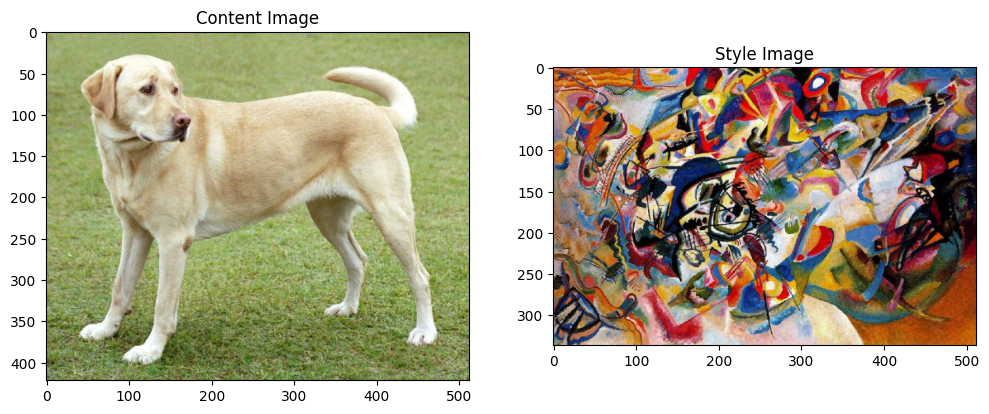

In [117]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

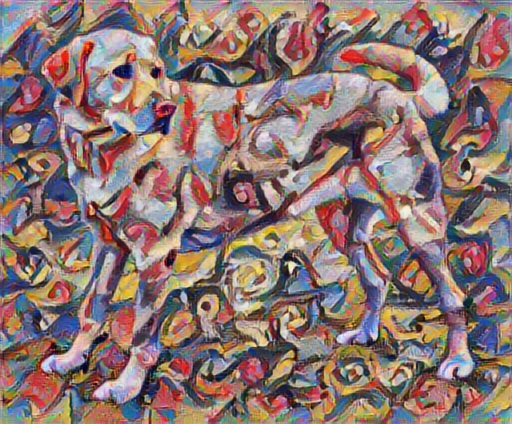

In [118]:
import tensorflow_hub as hub
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

In [119]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

574710816/574710816 [==============================] - 16s 0us/step


TensorShape([1, 1000])

In [120]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

35363/35363 [==============================] - 0s 0us/step


[('Labrador_retriever', 0.49317148),
 ('golden_retriever', 0.23665288),
 ('kuvasz', 0.036357507),
 ('Chesapeake_Bay_retriever', 0.02418274),
 ('Greater_Swiss_Mountain_dog', 0.01864608)]

In [121]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)


input_15
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [122]:
content_layers = ['block5_conv2']

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [123]:
def vgg_layers(layer_names):
  """ Creates a VGG model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on ImageNet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [124]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 336, 512, 64)
  min:  0.0
  max:  835.5256
  mean:  33.97525

block2_conv1
  shape:  (1, 168, 256, 128)
  min:  0.0
  max:  4625.8857
  mean:  199.82687

block3_conv1
  shape:  (1, 84, 128, 256)
  min:  0.0
  max:  8789.239
  mean:  230.78099

block4_conv1
  shape:  (1, 42, 64, 512)
  min:  0.0
  max:  21566.133
  mean:  791.24005

block5_conv1
  shape:  (1, 21, 32, 512)
  min:  0.0
  max:  3189.2537
  mean:  59.179478



In [125]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [127]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

In [128]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']
image = tf.Variable(content_image)
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
style_weight=1e-2
content_weight=1e4

In [129]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [130]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

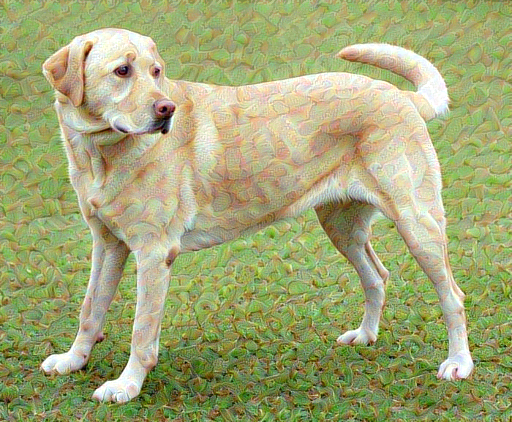

In [131]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

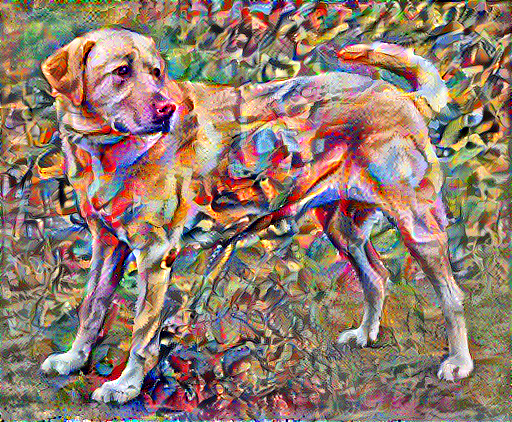

Train step: 1000
Total time: 75.8


In [132]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))